# INF200 Lecture No 12

###  28 November 2022 (digital lecture, recordings only)

## Today's topics

1. Optimization
    1. Algorithm analysis
    1. Benchmarking
    1. Profiling
1. Some practical approaches to optimization
    1. Use local variables
    1. Use arrays and canned methods (NumPy, SciPy)
    1. Details can matter
    1. Recommendations
1. Compiled Python Code
    1. Numba
    1. Effects of loop order
    1. Vectorizing
    1. Cython
1. Scientific computing: A complete example

### Note

The precise results of the benchmarks given in this notebook will vary depending on computer type and load. The factors describing differences in runtime are therefore only approximations.


In [1]:
from show_versions import show_versions
show_versions()

numpy        1.22.3  
scipy        1.9.3   
pandas       1.5.1   
matplotlib   3.5.3   


In [2]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = (10, 3)

----------------------

# Optimizing Code

One of the key ideas of Agile programming is to proceed as follows (Kent Beck):

1. Get it to work
1. Get it right
1. Get it fast

We have looked at the first two points, now we will turn to getting code fast.

See also introduction at end of Lecture 11.

## Algorithm analysis

### Summing numbers

Task: Compute the sum of all natural numbers up to $n$, i.e., $\sum_{k=1}^{n} k$.

#### Implementations

##### Loop

In [3]:
def sum_n_loop(n):
    s = 0
    for k in range(1, n+1):
        s += k
    return s

##### List comprehension

In [4]:
def sum_n_comp(n):
    return sum(range(1, n+1))

#### Tests

In [5]:
funcs = [sum_n_loop, sum_n_comp]
for func in funcs:
    assert func(1) == 1
    assert func(2) == 3
    assert func(3) == 6

#### Analysis

- How many operations are needed to complete the calculation?
- $n$ loop iterations
    - For each loop iteration
        - $1$ addition
        - $1$ step of the loop counter $k$
- Some operations to start function and return value
- Model of operation count
    - $a$ operations outside loop
    - $b$ operations inside loop for each iteration
    - $\Rightarrow a + b n$ operations
- Rough assumptions
    - All operations take the same time $c$
    - Then total time required: $T(n) \approx c(a+bn)$
    - For $n\gg 1$ we can ignore the constant, so $T(n)\sim n$ 
- The algorithm is *linear* in problem size
- In algorithm analysis, we say that the run-time is of order $n$, $T(n)=\Theta(n)$
- For details, take *INF221 Computer Science for Data Scientists*
    - [Course description](https://www.nmbu.no/course/INF221)

#### Algorithmic improvement

- From mathematics: $$\sum_{k=1}^n k = \frac{n(n+1)}{2}$$

##### Implementation based on analytical solution

In [6]:
def sum_n_ana(n):
    return (n * (n + 1)) / 2

##### Analysis of analytical-solution algorithm

- One addition, one multiplication, on division by $2$ *independent of problem size*
- $\Rightarrow T(n) = \mathrm{const}$ or $T(n)=\Theta(1)$
- Signficant improvement for $n\gg 1$
- Weaknesses
    - operations are only constant in time as long as integer type is fixed size
    - therefore, the analysis above holds strictly only up to a certain $n$

##### Re-run tests for all solutions

In [7]:
funcs = [sum_n_loop, sum_n_comp, sum_n_ana]
for func in funcs:
    assert func(1) == 1
    assert func(2) == 3
    assert func(3) == 6

### Sorting algorithms

Let us have quick look at sorting algorithms.

#### [Bubble sort](https://en.wikipedia.org/wiki/Bubble_sort)

- Simple sorting algorithm
    1. Start at beginning of list
    1. Compare neighboring entries
    1. If in wrong order, swap places
    1. When we get to end of array, largest element will be in last position
    1. Repeat from start, but for each round stop one position earlier

In [8]:
def bubble_sort(data):
    n = len(data)
    for j in range(n-1, 0, -1):
        for k in range(j):
            if data[k] > data[k + 1]:
                data[k], data[k + 1] = data[k + 1], data[k]

- Outer loop: $n-1$ iterations
- Inner loop: $j$ iterations
    - $1$ comparison
    - possibly $1$ swap
- Total number of inner-loop iterations: 
  $$\sum_{j=1}^{n-1} j=\frac{n(n-1)}{2}\sim n^2 \quad \text{for} \; n\gg 1$$
- Algorithm's run-time is *quadratic* in problem size, $T(n)\sim n^2$ or $T(n)=\Theta(n^2)$

#### Quicksort

- Divide-and-conquer sorting algorithm: subdivide sort into smaller and smaller tasks
- Invented by [C.A.R. Hoare](https://en.wikipedia.org/wiki/Tony_Hoare) around 1959
- Still one of the most used sorting algorithms
- See e.g. [Wikipedia](https://en.wikipedia.org/wiki/Quicksort)
- Basic idea:
    1. Choose a pivot element from the data
    1. Re-order data so that
        - all elements smaller than the pivot are left of the pivot
        - all elements larger than the pivot are right of the pivot
    1. Apply recursively on left and right side

In [9]:
def quicksort(data):
    _quicksort(data, 0, len(data))

def _quicksort(data, left, right):
    if right - left < 2:
        return

    pivot_idx = _partition(data, left, right)
    _quicksort(data, left, pivot_idx)
    _quicksort(data, pivot_idx + 1, right)

def _partition(data, left, right):
    if not left < right:
        return None

    right -= 1  
    pivot_idx = left
    pivot_val = data[pivot_idx]

    data[pivot_idx], data[right] = data[right], data[pivot_idx]
    store_idx = left

    for i in range(left, right):
        if data[i] < pivot_val:
            data[i], data[store_idx] = data[store_idx], data[i]
            store_idx += 1
    data[store_idx], data[right] = data[right], data[store_idx]

    return store_idx

- All work is done in `_partition`
    - one loop of length `right-left` or $n = r-l$
- How do $l$ and $r$ change as recursion progresses?
- Best case:
    - pivot splits data in half every time `_partition()` is called
    - then during recursion: $n \rightarrow n/2 \rightarrow n/4 \rightarrow \dots 1$
    - number of recursions required: $\log_2 n$
    - how often is `_partition` called?
        - top level: 1 time, data length $n$
        - first recursion: 2 times, data length $n/2$ for each
        - second recursion: 4 times, data length $n/4$ for each
        - ...
    - the total number of loop iterations is thus $n$ for each recursion level
    - $\Rightarrow \approx n \log_2 n$ loop iterations
    - Therefore, $T(n) \sim n\log n$ or $T(n)=\Omega(n\log n)$
- Worst case:
    - the first element is the pivot on each recursion
    - each call to `_partition()` returns one empty segement and one segment shorter by 1 only
    - number of recursions required: $n-1$
    - data lengths for recursions $n, n-1, n-2, \dots$
    - Therefore $T(n) \sim n^2$ or $T(n)=O(n^2)$
    - The algorithm is *quadratic*
- Illustrates importance of considering *best case*, *worst case* and *average case*.

##  Benchmarking: Empirical performance testing

- Also known as *benchmarking*
- Systematic testing of software performance
- Mostly speed, but also memory and increasingly energy consumption

### Timing code

- Code timing and profiling are *experiments*
- Subject to external disturbance, e.g., other activity on computer
- Results may depend on system used, both hardware and software: good documentation essential
- Timing/profiling runs must be done with realistic loads and last long enough ($>1$s), otherwise, you measure noise
- Many advanced profiling tools exploit special information from CPUs, but we won't discuss that here

#### Basic timing with `timeit`

- Jupyter magic automatically adjust number of repetitions
- We look at best results from N repetitions, since all slower results must be due to other activity in machine
- Still a good idea to repeat the same measurement several times


In [10]:
%timeit sum_n_loop(1000000)
%timeit sum_n_loop(1000000)
%timeit sum_n_loop(1000000)

50.9 ms ± 330 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
52.7 ms ± 235 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
48.2 ms ± 2.86 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
%timeit sum_n_comp(1000000)
%timeit sum_n_comp(1000000)
%timeit sum_n_comp(1000000)

12.6 ms ± 187 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.7 ms ± 258 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.6 ms ± 307 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


- We see some variation in run-times between repetitions
- Note that timeit automatically adjust the number of loops to ensure reliable results

In [12]:
%timeit sum_n_ana(1000000)
%timeit sum_n_ana(1000000)
%timeit sum_n_ana(1000000)

113 ns ± 0.878 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
113 ns ± 1.7 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
114 ns ± 2 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


- Analytical approch is more that 100.000 times faster!

### Manual benchmarks

#### Check for correctness

- Before benchmarking, make sure that algorithms work correctly
- Copy test data because sorting happens *in place*

In [13]:
test_data = np.random.random(1000)
bs_data = test_data.copy()
qs_data = test_data.copy()

bubble_sort(bs_data)
quicksort(qs_data)

assert all(bs_data[:-1] <= bs_data[1:])
assert all(qs_data[:-1] <= qs_data[1:])

- Looks fine, in real life we should test more extensively.

#### First attempt

In [14]:
bs_data = test_data.copy()
%timeit bubble_sort(bs_data)

80.2 ms ± 511 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
qs_data = test_data.copy()
%timeit quicksort(qs_data)

45.5 ms ± 1.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


- Quicksort is faster than bubble sort, as expected
- Are the results really plausible?
    - Bubble sort is $\Theta(n^2) = c_{\text{bs}}\times 1000^2$
    - Quicksort in average case is $\Omega(n\log_2 n) = c_{\text{qs}}\times 1000 \times \log_2 1000 \approx c_{\text{qs}}\times 1000 \times 10$
    - Would expect a factor near 100, got less than factor 2
    - Some of this can be explained by $c_{\text{qs}} > c_{\text{bs}}$
- What did we do wrong?

- Running quicksort on sorted data leads to worst case!
- `%timeit` runs sorting many times over
- We sort *in place*
- All except the first run is on sorted data!
- Solution: provide fresh data for each run

In [16]:
%timeit quicksort(test_data.copy())

3.52 ms ± 133 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
%timeit bubble_sort(bs_data.copy())

82.2 ms ± 1.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


- Quicksort now much faster
- Approximately 30 times faster than bubble sort, right order of magnitude
- Compare to Python's and NumPy's built-in sort functions 

In [18]:
%timeit sorted(test_data.copy())

221 µs ± 7.97 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [19]:
%timeit test_data.copy().sort()

11 µs ± 1.01 µs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


- Python `sorted()` is more than 15 times faster than quicksort
- NumPy `array.sort()` is another 22 times faster—Why?
    - Python `sorted()` is general for anything that can be sorted
    - NumPy `array.sort()` knows exactly what to sort and stores data contiguously

#### Scaling

- How does run-time change with problem size?
- Ususally tested with logarithmically-spaced data sizes
- We generate test data and benchmark bubble sort and quicksort
- Since we want to collect timing information, the `%timeit` magic is not useful
- Use `timeit` module
- Use Python's `copy.copy` to copy data before sort so that it works for any iterable data type, not just NumPy arrays

In [20]:
import timeit
import copy

In [21]:
def time_sort(sort_func, data, num_reps=1):
    """
    Returns times for repeated execution of sort_func(data).
    
    Automatically selects number of loops so execution takes
    at least 0.2 s.
    
    :param sort_func: sorting function to test
    :param data: data to sort
    :param num_reps: number of experiment repetitions
    """
    
    # Create Timer object; only objects named in globals are accessible 
    # to statement being timed
    timer = timeit.Timer('s_func(c_func(o_data))',
                         globals={'s_func': sort_func, 
                                  'c_func': copy.copy,
                                  'o_data': data})
    
    # Find out how many loops we need to run for > 0.2 s
    n_loops, t = timer.autorange()
    
    # Perform n_loops for each of num_reps repeats
    return np.array(timer.repeat(number=n_loops, repeat=num_reps)) / n_loops

#### Check that function gives consistent results with those above

In [22]:
time_sort(quicksort, test_data, num_reps=3)

array([0.0039835 , 0.00404323, 0.00395347])

- Looks good, about 3.5 ms

#### Create test data of different lengths

In [23]:
data_length = [2**n for n in range(1, 17)]
bench_data = [np.random.random(dl) for dl in data_length]
num_reps = 3

#### Create DataFrame to hold results

In [24]:
import pandas as pd

In [25]:
times = pd.DataFrame(columns=['Rep', 'Bubble', 'Quick', 'Python', 'NumPy'],
                     index=[dl for dl in data_length for _ in range(num_reps)])
times.Rep = list(range(num_reps)) * len(data_length)
times.head()

Rep Bubble Quick Python NumPy
2    0    NaN   NaN    NaN   NaN
2    1    NaN   NaN    NaN   NaN
2    2    NaN   NaN    NaN   NaN
4    0    NaN   NaN    NaN   NaN
4    1    NaN   NaN    NaN   NaN

#### Run benchmarks

- Start with small sizes
- If a benchmark takes too long, skip benchmarks for larger sizes for that algorithm

In [26]:
for sfunc, name in [(bubble_sort, 'Bubble'),
                    (quicksort, 'Quick'),
                    (sorted, 'Python'),
                    (lambda x: x.sort(), 'NumPy')]:
    for dlen, data in zip(data_length, bench_data):
        print(name[0], end='')
        res = time_sort(sfunc, data, num_reps=num_reps)
        if 10 * max(res) > 1:
            break
        times.loc[dlen, name] = res

BBBBBBBBBBQQQQQQQQQQQQQQQPPPPPPPPPPPPPPPPNNNNNNNNNNNNNNNN

In [27]:
times.loc[:, 'Bubble':].head()*1e6

Bubble     Quick    Python     NumPy
2  2.003352  2.441448  1.276105  0.934241
2  1.878788  2.373443   1.37887  0.886522
2  1.872332  2.476425  1.320036   0.90078
4   3.88343   5.82305  1.509434  0.897945
4  3.949945  4.353417  1.422393  0.902501

#### Plot results

- Linear and double-logarithmic plot
- Take mininmum across repetitions for each case

In [28]:
def plot_comparison(ax, name, func, func_text):
    line = [l for l in ax.lines if l.get_label() == name][0]

    x = line.get_xdata()
    y = line.get_ydata()
    max_ix = y.argmax()
    y_func = y[max_ix] / func(x[max_ix]) * func(x)

    color = line.get_color()
    ax.plot(x, y_func, color=color, linewidth=10, alpha=0.3, label=func_text)

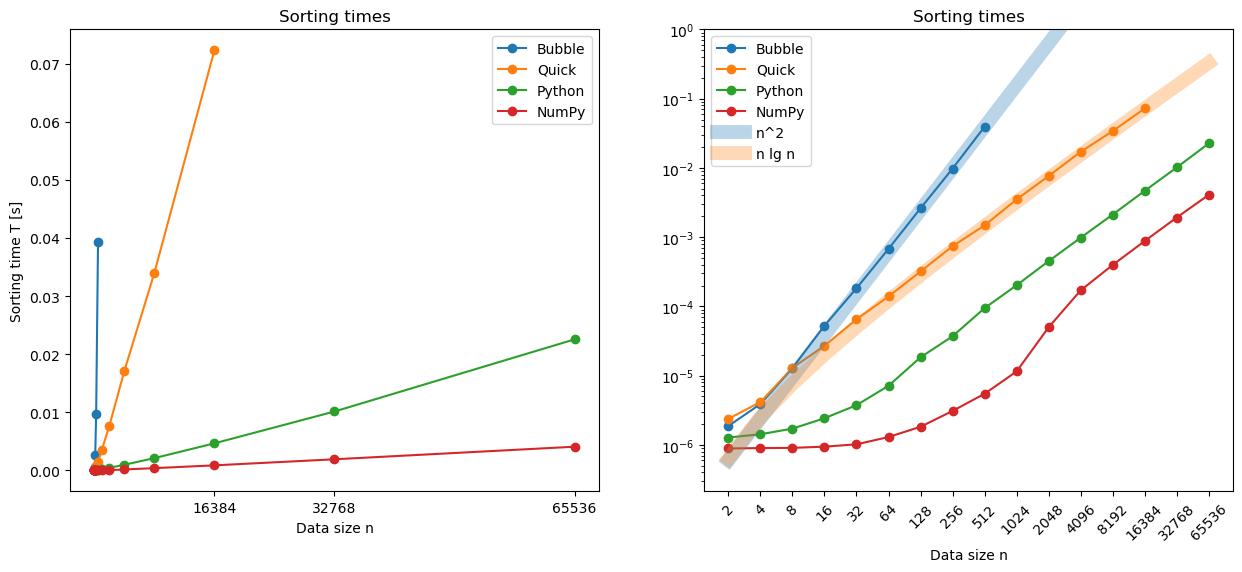

In [29]:
times_min = times.groupby(times.index).min().loc[:, 'Bubble':]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6));
times_min.plot(ax=ax1, title='Sorting times', style='o-');
ax1.set_xlabel('Data size n');
ax1.set_ylabel('Sorting time T [s]');
ax1.set_xticks(data_length[-3:]);

l2 = times_min.plot(ax=ax2, title='Sorting times', style='o-', loglog=True);
plot_comparison(ax2, 'Bubble', lambda n: n**2, 'n^2');
plot_comparison(ax2, 'Quick', lambda n: n * np.log2(n), 'n lg n');
ax2.set_ylim(None, 1);
ax2.set_xlabel('Data size n');
ax2.set_xticks(data_length);
ax2.set_xticklabels(data_length, rotation=45);
ax2.tick_params(axis='x', which='minor', bottom=False)
ax2.legend();

- Results fit well with expectations for large enough data size.
- To really verify that quicksort and built-in sorting follow $n \log n$, we would need use significantly larger data
- Built-in and especially NumPy sort show clearly different behavior for small data sizes
    - Most likely cache effects

-------------------------

## Profiling

- *Profiling* is the systematic investigation of *where* programs spend there time.
- You should always profile before optimizing: most guesses about where time is spent are wrong
- Experience shows that 10% of the code consume 90% of the time: focus on those 10%



### Profiling by function

- Profiling by function shows us how much time is spent in each function
- Supported in Python by [cProfile](https://docs.python.org/3.9/library/profile.html) package

In [30]:
import cProfile
cProfile.run('quicksort([6, 4, 3, 8, 3, 10])')

         18 function calls (10 primitive calls) in 0.000 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 2691321800.py:1(quicksort)
        4    0.000    0.000    0.000    0.000 2691321800.py:12(_partition)
      9/1    0.000    0.000    0.000    0.000 2691321800.py:4(_quicksort)
        1    0.000    0.000    0.000    0.000 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {built-in method builtins.len}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




- Running on such a small example gives very little information
- We can see that `_partition` was called 4 times
- `_quicksort` was called 9 times, in total, 1 time non-recursively 

In [31]:
data = np.random.random(1000000)
cProfile.run('quicksort(data.copy())')

         1999687 function calls (666567 primitive calls) in 8.379 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    8.374    8.374 2691321800.py:1(quicksort)
   666560    7.862    0.000    7.862    0.000 2691321800.py:12(_partition)
1333121/1    0.512    0.000    8.374    8.374 2691321800.py:4(_quicksort)
        1    0.000    0.000    8.379    8.379 <string>:1(<module>)
        1    0.000    0.000    8.379    8.379 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {built-in method builtins.len}
        1    0.005    0.005    0.005    0.005 {method 'copy' of 'numpy.ndarray' objects}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




#### What does this data show us ?
- Note: precise numbers may differ below due to re-runs of the profile
- `ncalls`: number of calls
    - for `_quicksort`, the one call is not recursive, all others recursive
    - the number of recursive `_quicksort` calls is twice the number of `_partition` calls
    - these numbers are consistent with our reading of the code
- `tottime`: total time spent in a function
    - 7.1s were spent in `_partition`, about 94% of the total run time
    - 0.5s were spent in `_quicksort`
- `percall`: time spent in function during a single call
- `cumtime`: time spent by a function and all functions calling it
    - 7.550s: "module" is our call to quicksort
    - 7.545s: `quicksort(data)`
    - 7.545s: `_quicksort()`
    - 7.079s: `_partition()`
        
#### Other  ways of profiling
- Profile in PyCharm
- Use the `%prun` magic in a notebook

In [32]:
data = np.random.random(100000)
%prun quicksort(data.copy())

         200032 function calls (66682 primitive calls) in 0.694 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    66675    0.639    0.000    0.639    0.000 2691321800.py:12(_partition)
 133351/1    0.054    0.000    0.693    0.693 2691321800.py:4(_quicksort)
        1    0.001    0.001    0.001    0.001 {method 'copy' of 'numpy.ndarray' objects}
        1    0.000    0.000    0.694    0.694 {built-in method builtins.exec}
        1    0.000    0.000    0.694    0.694 <string>:1(<module>)
        1    0.000    0.000    0.693    0.693 2691321800.py:1(quicksort)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
        1    0.000    0.000    0.000    0.000 {built-in method builtins.len}

### Line-wise profiling

- Often, we need more information: Where in `_partition` is time spent?
- Line profiling can help
- Python tool: [line_profiler](https://github.com/pyutils/line_profiler)
- See also [IPython Cookbook](https://ipython-books.github.io/43-profiling-your-code-line-by-line-with-line_profiler/)
- We need to import `line_profiler` as IPython extension
- We need to specify which functions to profile
- We use smaller data, since line profiling slows things considerably
- Results are shown at the bottom of the window

In [33]:
%load_ext line_profiler

- To run outside Jupyter:
    - add `@profile` decorators to all functions you want to decorate
    - run `kernprof -v -l quicksort.py`

In [34]:
data = np.random.random(100000)
%lprun -f _quicksort -f _partition quicksort(data.copy())

Timer unit: 1e-06 s

Total time: 3.85101 s
File: /var/folders/5k/0gyqhsf50418tc1x1l1t5lsw0000gn/T/ipykernel_34290/2691321800.py
Function: _quicksort at line 4

Line #      Hits         Time  Per Hit   % Time  Line Contents
     4                                           def _quicksort(data, left, right):
     5    133229      42798.0      0.3      1.1      if right - left < 2:
     6     66615      15294.0      0.2      0.4          return
     7                                           
     8     66614    3746631.0     56.2     97.3      pivot_idx = _partition(data, left, right)
     9     66614      22143.0      0.3      0.6      _quicksort(data, left, pivot_idx)
    10     66614      24148.0      0.4      0.6      _quicksort(data, pivot_idx + 1, right)

Total time: 2.44437 s
File: /var/folders/5k/0gyqhsf50418tc1x1l1t5lsw0000gn/T/ipykernel_34290/2691321800.py
Function: _partition at line 12

Line #      Hits         Time  Per Hit   % Time  Line Contents
    12                     

##### Results from line-wise profiling

- 97% of the time in `_quicksort()` is spent on the line calling `_partition()`
- Almost all time in `_partition()` is spent in the loop, lines 23-26
- `_quicksort()` line 6 is executed in (almost) exactly half the cases, because it is exeucted one every time the recursion terminates. For a balanced recursion tree, with $m$ levels, we have $2^m$ such recursion leaves. The total number of inner nodes of the tree are $\sum_{k=0}^{m-1} 2^k=2^m-1$.
- The loop header in `partition()`, line 23, is entered exactly 66.754 times more often than the first line in the loop body, line 24. This is precisely the number of loop iterations and reflects the final visit to the loop condition which raises `StopIteration` and ends the loop.
- In `_partition()` line 25, data is swapped approximately 50% of the time. This is plausible for random data.

--------------

# Some practical approaches to optimization

## Use local variables

- Performance can improve if we assign much-used member variables to locals inside methods
- Thanks to Runar Helin for drawing my attention to this point!
- Note
    - We need to make sure that every walk is the same to not confuse the benchmarking
    - Therefore, we seed `random` when constructing each walker and create a new walker for each trial

In [35]:
import random

class Walker:
    def __init__(self, x0, dest):
        random.seed(1234)
        self.x = x0
        self.dest = dest
        
    def walk(self):
        while self.x != self.dest:
            self.x += random.randint(-1, 1)
            
    def walk_local(self):
        x = self.x
        d = self.dest
        while x != d:
            x += random.randint(-1, 1)
        self.x = x

In [36]:
%timeit -r 5 -n 500 Walker(0, 10).walk()

383 µs ± 22 µs per loop (mean ± std. dev. of 5 runs, 500 loops each)


In [37]:
%timeit -r 5 -n 500 Walker(0, 10).walk_local()

351 µs ± 11.3 µs per loop (mean ± std. dev. of 5 runs, 500 loops each)


- About 10% speed-up
- Results are for Python 3.10
- **Note**: With Python 3.11, times in both cases times are around 220 µs!
    - https://docs.python.org/3/whatsnew/3.11.html#faster-cpython
    - https://devclass.com/2022/05/31/how-python-3-11-is-gaining-performance-at-the-cost-of-a-bit-more-memory/

## Use arrays and "canned" functions (NumPy,  SciPy)

- NumPy functions very fast if applied to NumPy arrays
    - Highly optimized "under the hood"
    - Use standard libraries such as [BLAS (Basic Linear Algebra Subprograms)](https://en.wikipedia.org/wiki/Basic_Linear_Algebra_Subprograms)
    - Anaconda Python uses [Intel Math Kernel Library (MKL)](https://en.wikipedia.org/wiki/Math_Kernel_Library) on computers with Intel CPUs
- Similar for higher-level SciPy functions such as
    - matrix decompositions and transformations
    - fast Fourier transforms
- Works best if applied to *arrays*
    - Standard `math` can be **faster if working on scalars**
    
### NumPy vs Math / Scalars vs Arrays

#### math module, scalar

In [38]:
import math

In [39]:
%timeit -r 1 [math.sin(x) for x in range(1000)]

107 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)


#### numpy module, scalar

In [40]:
%timeit -r 1 [np.sin(x) for x in range(1000)]

1.05 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1,000 loops each)


- `sin()` from NumPy is signficiantly slower when applied to scalars

#### numpy module, array

In [41]:
%timeit -r 1 np.sin(np.arange(1000))

8.86 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100,000 loops each)


- Applied to an array, NumPy is over 10 times faster

### Matrix-matrix multiplication

- Let $A$ be and $r\times s$ matrix and $B$ and $s\times t$ matrix
- Then $$C=A\times B$$ is a $r\times t$ matrix with elements $$C_{jk}=\sum_{m=1}^s A_{jm}B_{mk}$$

#### Python implementation

In [42]:
def mmm(A, B):
    r, s = A.shape
    _, t = B.shape
    assert s == B.shape[0]
    
    C = np.zeros((r, t))
    for j in range(r):
        for k in range(t):
            for m in range(s):
                C[j, k] += A[j, m] * B[m, k]
    return C

- Triple loop
- If $r=s=t$, there will be $r^3$ addition-multiplication operations

#### Comparison to built-in NumPy matrix-matrix multiplication

In [43]:
m100 = np.random.random((100, 100))
m1000 = np.random.random((1000, 1000))
m2500 = np.random.random((2500, 2500))
m10000 = np.random.random((10000, 10000))

In [44]:
%timeit -r 1 mmm(m100, m100)

432 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


- If we tried this with `m1000`, it would take $\approx 1000$ times longer $\approx$ 7 minutes
    - We won't try
    - $1000\times 1000$ matrix is *not*  large

In [45]:
%timeit -r 1 m100 @ m100

18.1 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100,000 loops each)


- NumPy's built-in matrix-matrix multiplication is 25.000 times faster!
- Try larger matrices

In [46]:
%timeit -r 1 m1000 @ m1000

11.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)


In [47]:
%timeit -r 1 m2500 @ m2500

183 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


- Scaling in keeping with or even better than $r^3$ expectation
    - Larger matrices may reduce effect of overhead
- Run very large matrix to have time to inspect process in Activity Monitor (Task Manager)

In [48]:
m10000 @ m10000;

- Python process running at $\approx 400$% load
    - Using all four cores of CPU automatically
    - Exploiting parallel computing
- Using `mkl_blas_avx2_dgemm_...` 
    - Uses MKL
    - Uses [AVX2 (Advanced Vector Extensions)](https://en.wikipedia.org/wiki/Advanced_Vector_Extensions) 
        - Simultaneous operation on 4 doubles
        - Hardware support for [FMA (fused-multiply add)](https://en.wikipedia.org/wiki/Multiply–accumulate_operation), i.e., for `c += a * b`
- See http://markus-beuckelmann.de/blog/boosting-numpy-blas.html for some more benchmark examples

## How details can matter—even when using NumPy functions

1. Create a square random matrix
1. Perform a mathematical operation on 
    1. a single column
    1. a single row
1. Compare times

In [49]:
mc = np.random.random((10000, 10000))

In [50]:
%timeit mc[:, 5] * 0.5

91 µs ± 9.7 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [51]:
%timeit mc[5, :] * 0.5

4.11 µs ± 130 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


- Multiplying a row is more than 20 times faster than multiplying a column
- Why?
- We can get the opposite result with a slight modification

In [52]:
mf = np.array(np.random.random((10000, 10000)), order='F')

In [53]:
%timeit mf[:, 5] * 0.5

3.67 µs ± 39.3 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [54]:
%timeit mf[5, :] * 0.5

79.6 µs ± 1.92 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


- The reason for this behavior is *memory layout* for arrays
- NumPy default:
    - C-style memory layout
    - Row elements contiguous in memory
    - Also called *row-major* ordering
- Alternative `order='F'`
    - FORTRAN-style memory layout
    - Column elements contiguous in memory
    - Also called *column-major* ordering
- Operations on contiguous memory are fast
    - Data can be moved much more efficiently to CPU

### Systematic analysis

- Above, we only looked at single array size
- To confirm results, we need to look at a range of sizes
- Focus on sizes that are powers of 2
    - Watch out for memory size: $16384\times 16384 \times 8\text{B}=2\text{GB}$

In [55]:
t_c_col = [(n, *timeit.Timer(stmt='mc[:, 5] * 0.5', 
                             setup='mc = np.random.random((n, n))', 
                             globals={'np': np, 'n': n}).autorange())
            for n in [2**k for k in range(3, 15)]]

In [56]:
tcc = pd.DataFrame(t_c_col)
tcc.columns = ['n', 'Loops', 'T_all']
tcc['T_stmt'] = tcc.T_all / tcc.Loops    # time per statement execution
tcc['T_op'] = tcc.T_stmt / tcc.n * 1e9   # time per single operation, in ns
tcc.set_index('n', inplace=True)

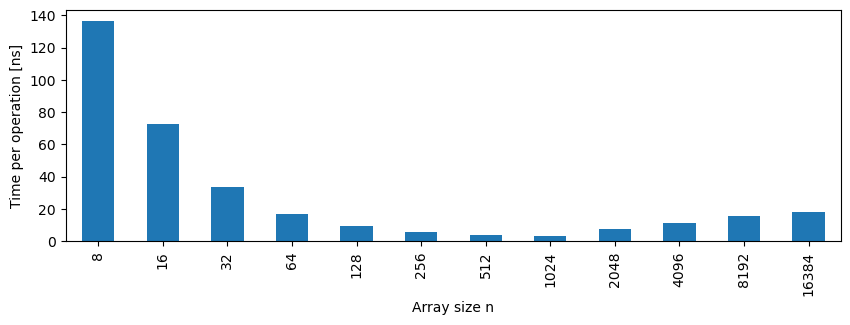

In [57]:
tcc.T_op.plot(kind='bar');
plt.xlabel('Array size n');
plt.ylabel('Time per operation [ns]');

- Looks like a "sweet spot" around matrix size $512\times 512$
- Probably dependent on how data is precisely fed in to CPU

### Create helper function to run more cases

In [58]:
def mat_op_timer(stmt, setup, sizes):
    """
    Time stmt using given setup for problem sizes given.
    
    setup must use "n" to determine size of test data.
    
    Returns dataframe with results.
    """
    
    res = pd.DataFrame(((n, *timeit.Timer(stmt=stmt, setup=setup,
                                          globals={'np': np, 'n': n}).autorange())
                        for n in sizes),
                        columns=['n', 'Loops', 'T_all'])
    res['T_stmt'] = res.T_all / res.Loops    # time per statement execution
    res['T_op'] = res.T_stmt / res.n * 1e9   # time per single operation, in ns
    res.set_index('n', inplace=True)
    return res

### Collect column-wise data

In [59]:
sz = [2**k for k in range(3, 16)]
tcc = mat_op_timer('mc[:, 1] * 0.5', 'mc = np.random.random((n, n))', sz)

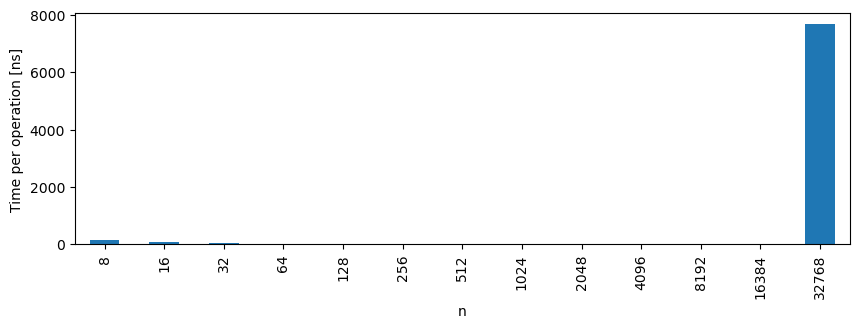

In [60]:
tcc.T_op.plot(kind='bar');
plt.ylabel('Time per operation [ns]');

- Consistent with result above

### Collect row-wise data

In [61]:
tcr = mat_op_timer('mc[1, :] * 0.5', 'mc = np.random.random((n, n))', sz)

In [62]:
tcr.T_op.plot(kind='bar');
plt.ylabel('Time per operation [ns]');

- Becomes extremely fast for large sizes
- Plot logarithmically 

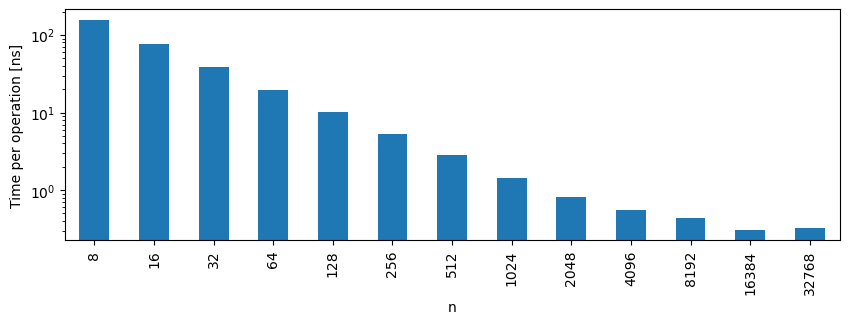

In [63]:
tcr.T_op.plot(kind='bar', logy=True);
plt.ylabel('Time per operation [ns]');

### Combine data for column- and row-wise operations

- Pandas `merge()` allows us to combine data from two DataFrames
    - We use the index (array size) to match rows from the two data frames
    - Columns will get suffixes `_c` and `_r` respectively
    - We also add a new column with the ratio of operation speeds

In [64]:
tc = pd.merge(tcc, tcr, on='n', suffixes=['_c', '_r'])
tc['T_op_c / T_op_r'] = tc.T_op_c / tc.T_op_r

In [65]:
tc.tail()

Loops_c   T_all_c  T_stmt_c       T_op_c  Loops_r   T_all_r  T_stmt_r  \
n                                                                              
2048     20000  0.328481  0.000016     8.019553   200000  0.329926  0.000002   
4096      5000  0.229439  0.000046    11.203054   100000  0.224916  0.000002   
8192      2000  0.249841  0.000125    15.249114   100000  0.355441  0.000004   
16384     1000  0.341894  0.000342    20.867529    50000  0.252051  0.000005   
32768        1  0.251359  0.251359  7670.862608    20000  0.215780  0.000011   

         T_op_r  T_op_c / T_op_r  
n                                 
2048   0.805483         9.956205  
4096   0.549111        20.402159  
8192   0.433888        35.145294  
16384  0.307679        67.822363  
32768  0.329254     23297.699574

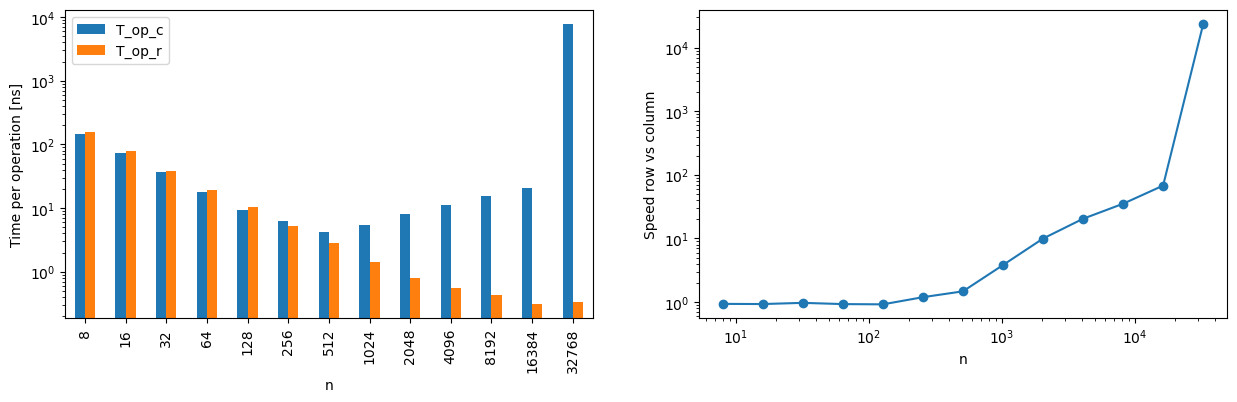

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
tc.loc[:, ['T_op_c', 'T_op_r']].plot(kind='bar', ax=ax[0], logy=True);
ax[0].set_ylabel('Time per operation [ns]');
tc.loc[:, 'T_op_c / T_op_r'].plot(marker='o', ax=ax[1], logx=True, logy=True);
ax[1].set_ylabel('Speed row vs column');

- For small sizes, memory layout makes no difference
- For large sizes, row-wise operations *much* faster than column-wise
    - Absolute time per operation seems to level-off around 0.3ns
    - For a 2 GHz CPU, this time is *shorter than CPU clock cycle* (0.5 ns)
    - Possible because [AVX512](https://en.wikipedia.org/wiki/AVX-512) vector operations work on up to 8 doubles simultaneously
    
### Further steps

- Multiple repetitions of experiment to estimate statistical error of measurements
- Current `autorange()` use is inefficient, find more intelligent approach
- Also measure for Fortran memory layout
- Test array sizes that are not power of 2.

## Recommendations

- Attempt to formulate problems so that you can use NumPy array operations
- May in some cases be worth "detours"
- Also known as *vectorization*
- Difficult or impossible if next step depends on earlier results
    - Fibonacci numbers
    - Random walk
- See also
    - Nicolas P. Rougier, *From Python to NumPy*, https://github.com/rougier/from-python-to-numpy
    - Nicolas P. Rougier, *100 numpy exercises*, https://github.com/rougier/numpy-100/blob/master/100_Numpy_exercises.ipynb

-------

# Compiled Python code

- See also Ch 19 of [Johansson's *Numerical Python*](http://jrjohansson.github.io/numericalpython.html).
- Key problem
    - Python is an *interpreted* language
    - Interpreter must be "prepared for everything"
    - Data types for operands never known in advance
- Idea: Just-in-time compilation (JIT)
    - Compile Python code into executable machine code
    - Inspect function arguments to find data types
    - Taylor code as much as possible to data type at hand
- Two widely used packages
    - [Numba](http://numba.pydata.org)
    - [Cython](http://cython.org)
    
## Numba

### First example: Fibonacci numbers

- Just add decorator and obtain compiled function

In [67]:
import numba

In [68]:
def fib_fw(n):
    f, f_prev = 1, 1
    for _ in range(3, n+1):
        f, f_prev = f + f_prev, f
    return f

@numba.jit
def fib_fw_jit(n):
    f, f_prev = 1, 1
    for _ in range(3, n+1):
        f, f_prev = f + f_prev, f
    return f

In [69]:
fib_fw(10), fib_fw_jit(10)

(55, 55)

- Looks good, same results
- Let's try larger numbers

In [70]:
fib_fw(500)

139423224561697880139724382870407283950070256587697307264108962948325571622863290691557658876222521294125

In [71]:
fib_fw_jit(500)

2171430676560690477

- What has happened?
- Result from JIT-compiled function **clearly wrong**!

In [72]:
import math

In [73]:
math.log2(2171430676560690477)

60.91335160311821

- Result from JIT-compiled function is close to $2^{64}$
- JIT-compiled function here uses 64-bit integers for all numbers internally
- Suffers from numerical overflow
- We can force Numba to use Python integers internally

In [74]:
@numba.jit(forceobj=True)
def fib_fw_jit_py_int(n):
    f, f_prev = 1, 1
    for _ in range(3, n+1):
        f, f_prev = f + f_prev, f
    return f

In [75]:
fib_fw_jit_py_int(500)

139423224561697880139724382870407283950070256587697307264108962948325571622863290691557658876222521294125

##### Performance comparison

In [76]:
%timeit -r 1 fib_fw(500)

33.7 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)


In [77]:
%timeit -r 1 fib_fw_jit(500)

477 ns ± 0 ns per loop (mean ± std. dev. of 1 run, 1,000,000 loops each)


In [78]:
%timeit -r 1 fib_fw_jit_py_int(500)

36.1 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)


- Incorrect version is much faster, but **useless**
- Correct version is slower after JIT compilation than pure Python
- When working with Python's long integers, JIT may not be particularly useful (but often in other cases!)

### Example: Matrix-matrix multiplication

- Instructive, even if we cannot expect to achieve performance provided by NumPy

In [79]:
@numba.jit
def mmm_jit_jkm(A, B):
    r, s = A.shape
    _, t = B.shape
    assert s == B.shape[0]
    
    C = np.zeros((r, t))
    for j in range(r):
        for k in range(t):
            for m in range(s):
                C[j, k] += A[j, m] * B[m, k]
    return C

In [80]:
%timeit -r 1 mmm_jit_jkm(m100, m100)

1.65 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [81]:
%timeit -r 1 mmm_jit_jkm(m100, m100)

1.05 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1,000 loops each)


- May need to run timing twice, first time function is compiled, which may cause overhead
- Over 400 times faster than pure Python version
- And that by adding a single line!
- But are results trustworthy?

In [82]:
c_np = m100 @ m100
c_py = mmm(m100, m100)
c_jit = mmm_jit_jkm(m100, m100)

In [83]:
print(np.abs(c_py-c_np).max() / c_np.max())
print(np.abs(c_jit-c_np).max() / c_np.max())
print(np.abs(c_jit-c_py).max() / c_np.max())

3.08222590958453e-16
3.08222590958453e-16
0.0


- Results are identical within limits of numerical precision.

#### Effects of loop order

- Change order in which we loop over `j`, `k`, `m`
- Expect identical results
- What is the effect on runtime?

In [84]:
@numba.jit
def mmm_jit_mjk(A, B):
    r, s = A.shape
    _, t = B.shape
    assert s == B.shape[0]
    
    C = np.zeros((r, t))
    for m in range(s):
        for j in range(r):
            for k in range(t):
                C[j, k] += A[j, m] * B[m, k]
    return C

In [85]:
@numba.jit
def mmm_jit_mkj(A, B):
    r, s = A.shape
    _, t = B.shape
    assert s == B.shape[0]
    
    C = np.zeros((r, t))
    for m in range(s):
        for k in range(t):
            for j in range(r):
                C[j, k] += A[j, m] * B[m, k]
    return C

In [86]:
c_mjk = mmm_jit_mjk(m100, m100)
c_mkj = mmm_jit_mkj(m100, m100)
print(np.abs(c_jit-c_mjk).max() / c_jit.max())
print(np.abs(c_jit-c_mkj).max() / c_jit.max())

0.0
0.0


In [87]:
%timeit -r 1 mmm_jit_jkm(m1000, m1000)

1.63 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [88]:
%timeit -r 1 mmm_jit_mjk(m1000, m1000)

1.04 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [89]:
%timeit -r 1 mmm_jit_mkj(m1000, m1000)

4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [90]:
%timeit -r 1 m1000 @ m1000

11.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)


- Large difference in run-time for *almost* the same code
- Only difference: loop order
- Caused by different memory access patterns
    - Memory is slow compared to CPU
    - Operations slowed down if CPU needs to wait for data from RAM
    - Fast but small *caches* buffer often-used data
    - Improves performance, but only if the right data is in cache
- Note that our JIT-code is still *a lot*  slower than NumPy's built-in matrix multiplication

### Vectorizing with Numba

- NumPy's `np.sin()` is fast on arrays because it applies the function directly to all elements of the array
- How can we achieve this for our own functions?
- Consider the following test function

In [91]:
def f(x):
    return (x**3-x**0.5)/(1+x**2)

##### Run as scalar function

In [92]:
%timeit -r 1 [f(x) for x in range(1000)]

689 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1,000 loops each)


##### Run on NumPy arrays

In [93]:
%timeit -r 1 f(np.arange(1000))

33.2 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)


- 25 times faster just working on arrays
- But NumPy needs to create many intermediary arrays for subexpressions, e.g., `x**3`, `x**0.5`
- Would be nice to create a functions that can be applied directly to each element as efficient as `np.sin()`
- Provided by Numba's `vectorize` decorator

In [94]:
@numba.vectorize
def f_vec(x):
    return (x**3-x**0.5)/(1+x**2)

In [95]:
%timeit -r 1 f_vec(np.arange(1000))

3.16 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100,000 loops each)


- Gained another factor 10
- Especially useful for functions that do not work on arrays directly

In [96]:
def step(x):
    return 0 if x <= 0 else 1

In [97]:
step(-2 + np.arange(5))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [98]:
@numba.vectorize
def step_vec(x):
    return 0 if x <= 0 else 1

In [99]:
step_vec(-2 + np.arange(5))

array([0, 0, 0, 1, 1])

## Cython

- Similar idea as Numba
- Slightly more difficult to use (but easy from notebooks)
- Allows more detailed specifications
- Translates into C-code first, then compiles
- Also widely used to wrap existing C-code for use from Python
- NumPy is largely implemented using Cython

### Cython in the Notebook

- Need to load `cython` notebook extension

In [100]:
%load_ext cython

- Can now cythonize code using cell magic
- Must import required modules in cell
- `cimport` line imports also cython version of NumPy

In [101]:
%%cython -a

cimport numpy as np
import numpy as np 

def mmm_cy_mjk(A, B):
    r, s = A.shape
    _, t = B.shape
    assert s == B.shape[0]
    
    C = np.zeros((r, t))
    for m in range(s):
        for j in range(r):
            for k in range(t):
                C[j, k] += A[j, m] * B[m, k]
    return C

In [102]:
c_cy = mmm_cy_mjk(m100, m100)
np.abs(c_cy-c_jit).max()

0.0

In [103]:
%timeit -r 1 mmm_cy_mjk(m100, m100)

403 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


- Only marginally faster than our original pure Python implementation
- Not surprising, since almost all lines above have Python interactions
- We need to provide more information about arguments and variables to get pure C code

In [104]:
%%cython -a

import cython
cimport numpy as np
import numpy as np 

@cython.boundscheck(False)
@cython.wraparound(False)
def mmm_cyc_mjk(np.ndarray[np.float64_t, ndim=2] A, 
                np.ndarray[np.float64_t, ndim=2] B):
    cdef int r = A.shape[0]
    cdef int s = A.shape[1]
    cdef int t = B.shape[1]
    assert s == B.shape[0]
    
    cdef np.ndarray[np.float64_t, ndim=2] C = np.zeros((r, t), 
                                                       dtype=A.dtype)
    cdef int j, k, m
    for m in range(s):
        for j in range(r):
            for k in range(t):
                C[j, k] += A[j, m] * B[m, k]
    return C

In [105]:
c_cyc = mmm_cyc_mjk(m100, m100)
np.abs(c_cyc-c_jit).max()

0.0

In [106]:
%timeit -r 1 mmm_cyc_mjk(m100, m100)

582 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1,000 loops each)


- Almost 700 times faster than first Cython version
- Let's try on larger matrix for comparison with Numba

In [107]:
%timeit -r 3 mmm_cyc_mjk(m1000, m1000)

743 ms ± 4.89 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [108]:
%timeit -r 3 mmm_jit_mjk(m1000, m1000)

1.01 s ± 29.7 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


- The Numba version is somewhat slower but considerably less work
- Built-in multiplocation still wins by a factor 60

In [109]:
%timeit -r 3 m1000@m1000

11.4 ms ± 143 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


-------------

# Scientific computing: A complete example

We will now use NumPy to analyse Chutes & Ladders not through simulation, but by modeling a stochastic process.

The game has two important properties:

- The movement of each player is completely independent of the
  movements of all other players as long as no player reaches
  field 90.
- Each move is completely determined by the current position of the figure and the cast of the die.

Therefore, each move does not depend on the past moves of the
figure in any other way than through the current position of the
figure. Because the future depends on the past only through the
present position of the figure, the movement of the figure is a
[Markov process](https://en.wikipedia.org/wiki/Markov_process). Markov
processes play an important role in modeling of a large range of
systems in biology, physics, economy etc.

An interesting question is how long games last, i.e., how many moves a
player has to make before reaching or passing field 90. The number of
moves will vary from game to game, and we are interested in the
probability distribution for the duration of the game. This is a
*first-passage-time problem*, an important class of problems first
studied by Erwin Schrödinger in 1915 (Zur Theorie der Fall- und
Steigversuche an Teilchen mit Brownscher Bewegung. *Physikalische
Zeitschrift* **16**:289–295, 1915).


### Background

The movement of the walker is a [Markov process](https://en.wikipedia.org/wiki/Markov_process), because the result of a single move depends only on the current position $j$ of the walker and the roll of the die. The entire history, i.e., *how* the walker got to position $j$ does not matter. Such processes are highly relevant in many branches of science and technology. One example of their use in neuroscience is in my PhD thesis ([Plesser, 1999](http://arken.nmbu.no/~plesser/publications/HEPlesser_PhD.pdf)). We can use techniques for Markov processes to study the movement of the walker in the Chutes & Ladders game.

Instead of obtaining the distribution of times to goal using simulation, we can also obtain it by numerical computation (or, using, e.g. SymPy, even exact). Let ${p^{(k)}}$ be a vector with elements $p^{(k)}_j$ ($0\leq j \leq G$) representing the probability probability that the walker is at position $j$ after move $k$. As initial conditions, we have
\begin{align}
p^{(0)}_0 &= 1\\
p^{(0)}_j &= 0\quad\mathrm{for}\; j>0
\end{align}
Let $M$ be a matrix that describes the how a single move changes the probabilities for the location of the walker. Specifically, let $M_{ij}$ be the probability that a walker in position $j$ will move to position $i$ in the next move. 
Let us first consider a game without chutes and ladders. The walker will then with equal probability move to one of the next six positions, except for the last few positions on the board, where any move will stop at $G$. We therefore have
\begin{align}
M_{0j} &= 0 \qquad\mathrm{(can\,never\,return\,to\,0)} \\
M_{ij} &= 1/6 \quad\mathrm{for}\; j+1\leq i \leq j+6 \;\mathrm{and}\; i < G\\
M_{Gj} &= 0 \quad\mathrm{for}\; j < G-6 \\
M_{Gj} &= 1 - (G-j-1)/6 \quad\mathrm{for}\; G-6 \leq j < G \\
M_{GG} &= 1\\
M_{ij} &= 0 \quad\mathrm{else}
\end{align}

We can then describe the motion of the walker across the board by the following equation:

\begin{equation}
p^{(k+1)} = M \times p^{(k)} \;.
\end{equation}

To obtain the probability distribution for the time to arrive at the goal $G$, we consider $p^{(k)}_G$, which corresponds to the probability that the walker has reached the goal after at most $k$ moves. If $G=6n$, then the goal can at the earliest be reached after $n$ moves (all sixes, probability $(1/6)^n$), and must at the latest be reached after $G$ moves ($G$ ones, probability $(1/6)^G$), i.e.,

\begin{align}
p^{(k)}_G &= 0 \quad\mathrm{for}\; k < n \\
p^{(n)}_G &= (1/6)^n \\
p^{(G)}_G &= 1
\end{align}

These cases provide test cases. Note that $Q_k=p^{(k)}_G$ is the *cumulative*  probability of arrival by step $k$. The probability for arriving *at* step $k$ is 
$$q_k = Q_k - Q_{k-1}\;.$$

Let us now assume that we have a ladder from $r$ to $s$ (chutes work the same way). Then the probability for the walker to move to $r$ will be $0$, and the corresponding probability will be "moved" to $s$. Specifically, based on matrix $M$ from above, we can defined matrix $L$ as follows:
\begin{align}
L_{rj} &= 0 \quad \forall j \qquad\mathrm{(no\,moves\,to\,r)}\\
L_{sj} &= M_{sj} + M_{rj}\quad \forall j \qquad\mathrm{(moves\,to\,s\,instead\,of\,r)}\\
L_{ij} &= M_{ij}\quad\mathrm{else}
\end{align}

### Implementation

We defined $p$ as an array with one column per time point we are interested in, and one row per position. We add some extra columns to ensure all is stationary after $G$ steps and to avoid confusion about which matrix dimension is what.

In [110]:
p = np.zeros((91, 100))
p[0, 0] = 1

In [111]:
M = np.zeros((91, 91))
M[90, 90] = 1
M[90, 84:90] = np.array([1., 2., 3., 4., 5., 6.]) / 6.
for i in range(1, 90):
    M[i, max(0, i-6):i] = 1./6.

In [112]:
for k in range(1, 100):
    p[:, k] = M @ p[:, k-1]

In [113]:
plt.rcParams['savefig.dpi'] = 120          
plt.rcParams['figure.figsize'] = (12., 6.)

In [114]:
plt.matshow(M);
plt.xlabel('Current board position $j$');
plt.ylabel('Next board position $i$');
plt.title('Transistion matrix for plain board');
ax = plt.colorbar(shrink=0.7);

- The broad band slighly below the diagonal represents normal moves.
- Accumulation of probability in position $G=90$ is visible in the bottom right corner.

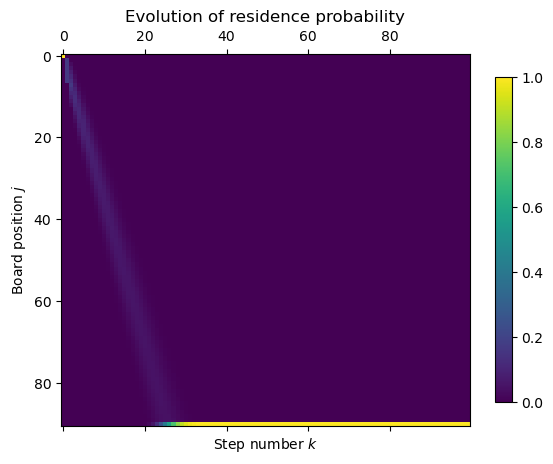

In [115]:
plt.matshow(p)
plt.xlabel('Step number $k$');
plt.ylabel('Board position $j$');
plt.title('Evolution of residence probability');
ax = plt.colorbar(shrink=0.7);

#### Improving the figures

- Graphs are a bit difficult to read due to low contrast
- We define a function providing nice plotting
- For details on the plotting functions, **see the end of this part of the notebook**

In [116]:
import matplotlib.cm as cm

def prettymat(m):
    cm7 = cm.get_cmap('YlGnBu_r', 7)
    cm7list = [cm7(i) for i in range(cm7.N)]
    cm7list[0] = [0.9, 0.9, 0.9]
    cm7mod = cm7.from_list('mymap', cm7list, cm7.N)
    plt.matshow(m, cmap=cm7mod)
    cax = plt.colorbar(shrink=0.7);
    cax.set_ticks(np.arange(0., 7.) / 7. + 1./14.);
    cax.set_ticklabels(('0', '1/6', '1/3', '1/2', '2/3', '5/6', '1'));
    plt.xlabel('Current board position $j$');
    plt.ylabel('Next board position $i$');
    plt.title('Transistion matrix for plain board');

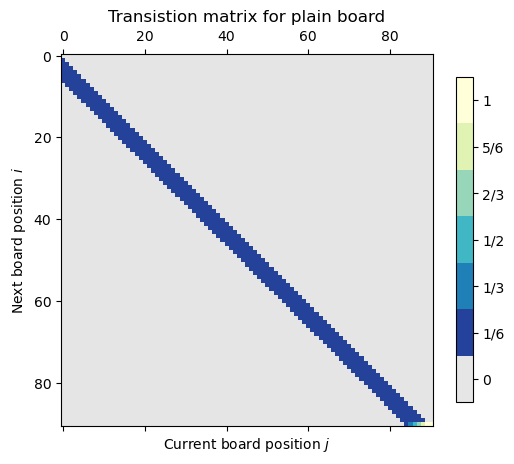

In [117]:
prettymat(M);

In [118]:
from matplotlib.colors import PowerNorm

def prettyprob(p):
    p_cutoff = 0.001
    cm_p = cm.get_cmap('YlGnBu_r')
    plt.matshow(p, cmap=cm_p,
                norm=PowerNorm(gamma=0.2, vmin=p_cutoff, vmax=1))
    plt.xlabel('Step number $k$');
    plt.ylabel('Board position $j$');
    plt.title('Evolution of residence probability');
    cax = plt.colorbar(shrink=0.8, extend='min');
    cax.set_ticks([p_cutoff, 0.002, 0.005, 0.01, 0.02, 0.05, 
                   0.1, 0.2, 0.5, 1.0]);

In [119]:
prettyprob(p)

#### Arrival time probabilities

In [120]:
Q = p[90, :]
q = np.zeros_like(Q)   # fiddle a little to avoid zero-indexing trouble
q[1:] = np.diff(Q)

In [121]:
plt.step(range(100), Q, where='mid');
plt.title('Cumulative distribution of arrival times')
plt.xlabel('Number of steps');
plt.ylabel('$Q_k$');

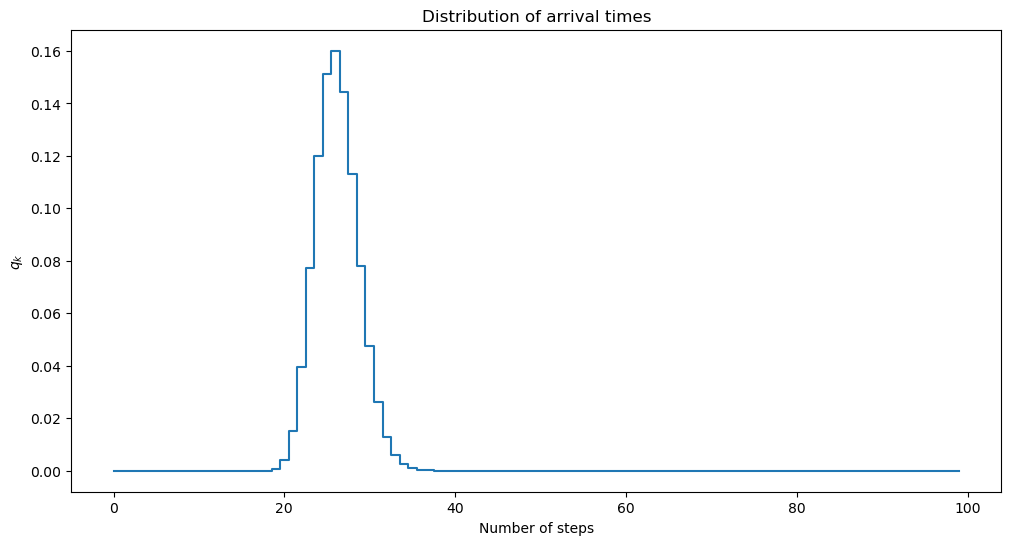

In [122]:
plt.step(range(100), q, where='mid');
plt.title('Distribution of arrival times')
plt.xlabel('Number of steps');
plt.ylabel('$q_k$');

Let's check the border cases

In [123]:
Q[14], Q[15], (1./6.)**15, Q[15]-(1./6.)**15

(0.0, 2.126822490730477e-12, 2.126822490730477e-12, 0.0)

In [124]:
q[90]

0.0

In [125]:
Q[89]-1, Q[90]-1

(-1.3322676295501878e-15, -1.3322676295501878e-15)

In [126]:
(1./6.)**90

9.255235320869914e-71

Okay, probabilities for long game durations are far below numerical precision, therefore we do not see exact values in the tail of the distribution. But the error of $\mathcal{O}(10^{-15})$ is acceptable.

#### Matrix with chutes and ladders

We first define the standard set of chutes and ladders.

In [127]:
cnl = {1: 40, 8: 10, 36: 52, 43: 62, 49: 79, 65: 82, 68: 85,
       24: 5, 33: 3, 42: 30, 56: 37, 64: 27, 74: 12, 87: 70}

In [128]:
L = M.copy()
for start, dest in cnl.items():
    L[start, :] = 0.
    L[dest, :] += M[start, :]

In [129]:
prettymat(L)

- The broad band slighly below the diagonal represents normal moves.
- Stripes above the diagonal represent chutes.
- Stripes below the broad band represent ladders.
- The bright blue bar in the top-left corner is the $8\to 10$ ladder which is so short it overlaps with normal movement.
- The $1	\to 40$ ladder is visible as a single bright blue pixel on row 40.
- Accumulation of probability in position $G=90$ is visible in the bottom right corner.

In [130]:
pL = np.zeros((91, 300))
pL[0, 0] = 1
for k in range(1, pL.shape[1]):
    pL[:, k] = L @ pL[:, k-1]

In [131]:
QL = pL[90]
qL = np.zeros_like(QL)
qL[1:] = np.diff(QL)

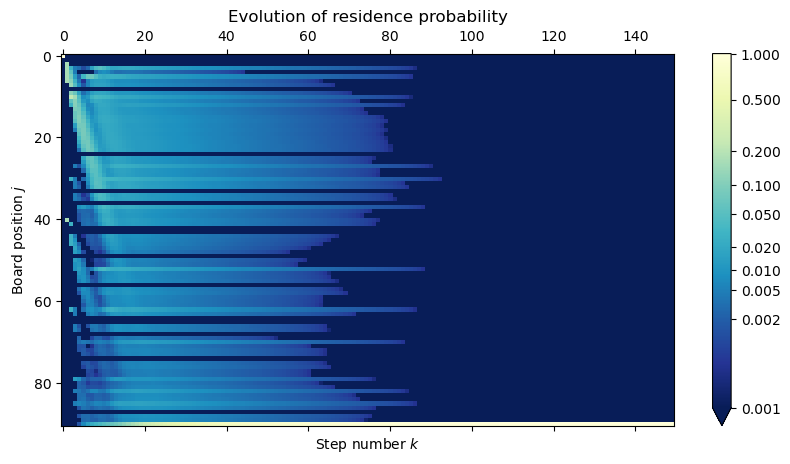

In [132]:
prettyprob(pL[:, :150])

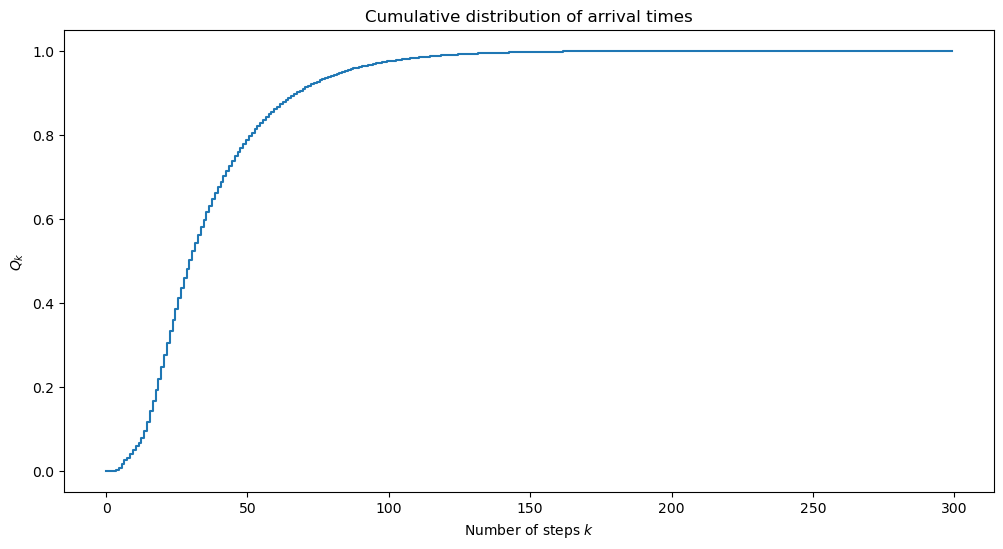

In [133]:
plt.step(range(len(QL)), QL, where='mid');
plt.title('Cumulative distribution of arrival times')
plt.xlabel('Number of steps $k$');
plt.ylabel('$Q_k$');

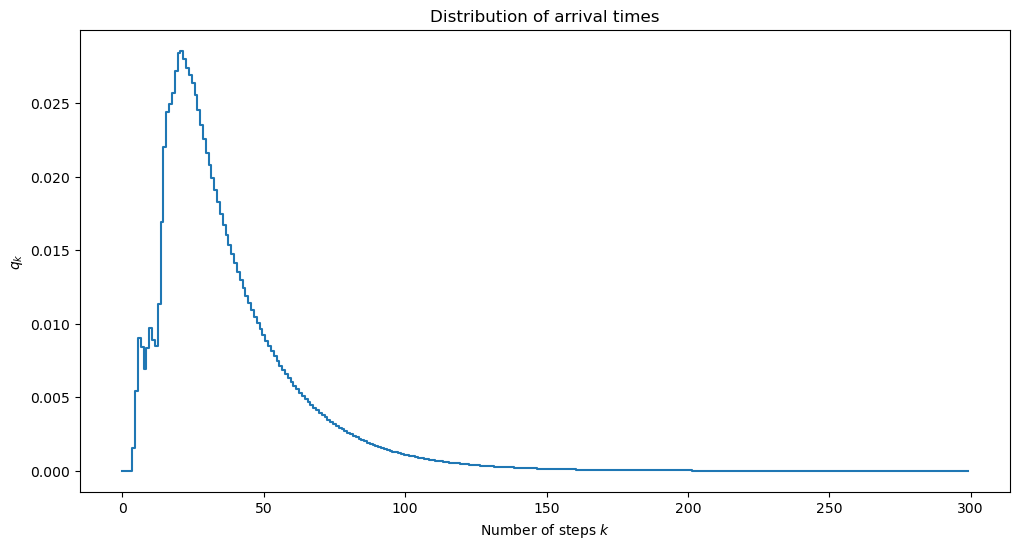

In [134]:
plt.step(range(len(qL)), qL, where='mid');
plt.title('Distribution of arrival times')
plt.xlabel('Number of steps $k$');
plt.ylabel('$q_k$');

We know that the shortest path is 4 steps, requiring a precise sequence of die casts, i.e., it has probability $6^{-4}$. We can check this:

In [135]:
print("No one should make it in three moves                   :", qL[3])
print("It is possible to make it in four moves                :", qL[4])
print("If there is a single way to do it four moves, we expect:", (1./6.)**4)
print("If there are two ways to do it in four moves, we expect:", 2 * (1./6.)**4)
print("Difference between results and two-ways expectation    :", qL[4] - 2 * (1./6.)**4)

No one should make it in three moves                   : 0.0
It is possible to make it in four moves                : 0.0015432098765432098
If there is a single way to do it four moves, we expect: 0.0007716049382716048
If there are two ways to do it in four moves, we expect: 0.0015432098765432096
Difference between results and two-ways expectation    : 2.168404344971009e-19


So apparently there are two ways to do it in four steps. Inspection of the board reveals the following possibilities:

1. Roll 1, then take ladder from 1 to 40.
1. Roll 3, then take ladder from 43 to 62.
1. Roll 6, then take ladder from 68 to 85.
1. From 85, you can reach 90 by either rolling 5 or 6.

Therefore, there are indeed exactly two ways of reaching the goal with four moves.

Furthermore, we can check that $Q_k	\to 1$ for $k	\to\infty$:

In [136]:
1 - QL[-1]

5.445159400263577e-06

This indicates convergence to $1$, but at the same time a rather long tail. We can plot semilogarithmically to see the tail better:

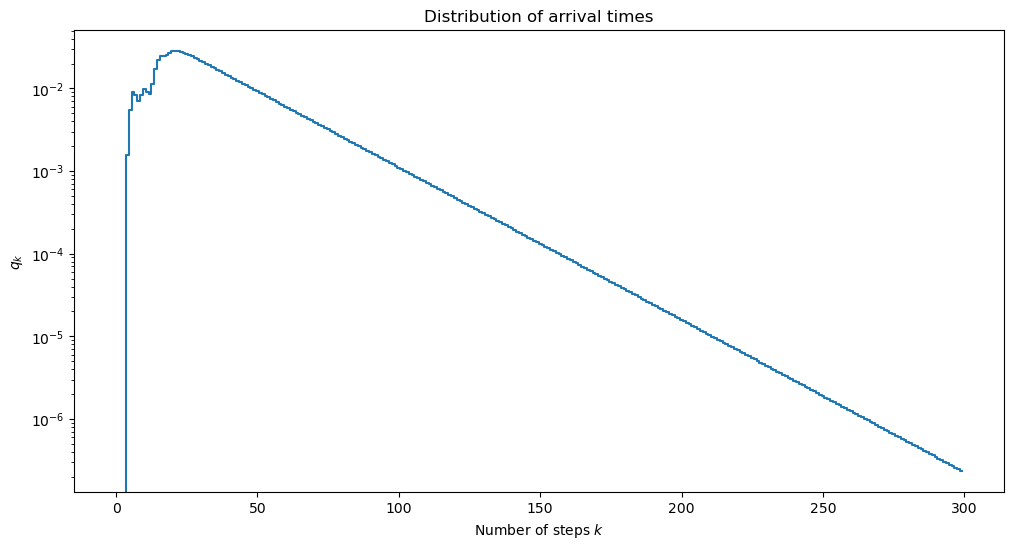

In [137]:
plt.step(range(len(qL)), qL, where='mid');
plt.yscale('log')
plt.title('Distribution of arrival times')
plt.xlabel('Number of steps $k$');
plt.ylabel('$q_k$');

The tail of the distribution is linear in the semilogarithmic plot, indicating that it follows an exponential distribution. For more detailed characterization, we could fit the distribution for $k>50$ to an exponential distribution; we leave this as an exercise.

#### Comparison with simulation

In [138]:
from chutes_v7_board_file import Experiment, Board

In [139]:
d = Experiment(board=Board(goal=90, chutes_and_ladders=cnl),
               num_games=20000, num_players=1, seed=1234567).execute()

In [140]:
qE = np.zeros(max(d)+1, dtype=float)
for n in frozenset(d):
    qE[n] = d.count(n)
qE /= len(d)

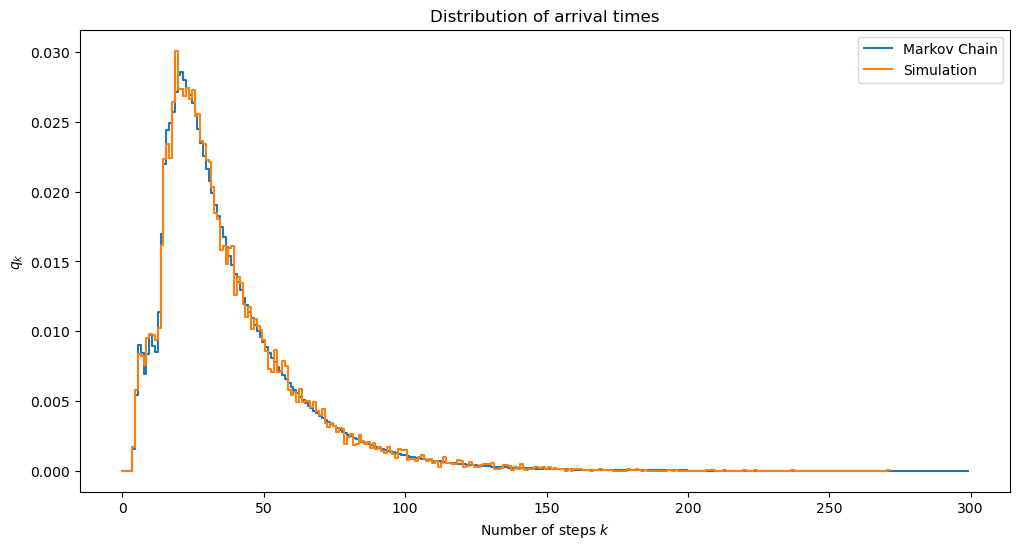

In [141]:
plt.step(range(len(qL)), qL, where='mid', label='Markov Chain');
plt.step(range(len(qE)), qE, where='mid', label='Simulation');
plt.title('Distribution of arrival times')
plt.xlabel('Number of steps $k$');
plt.ylabel('$q_k$');
plt.legend();

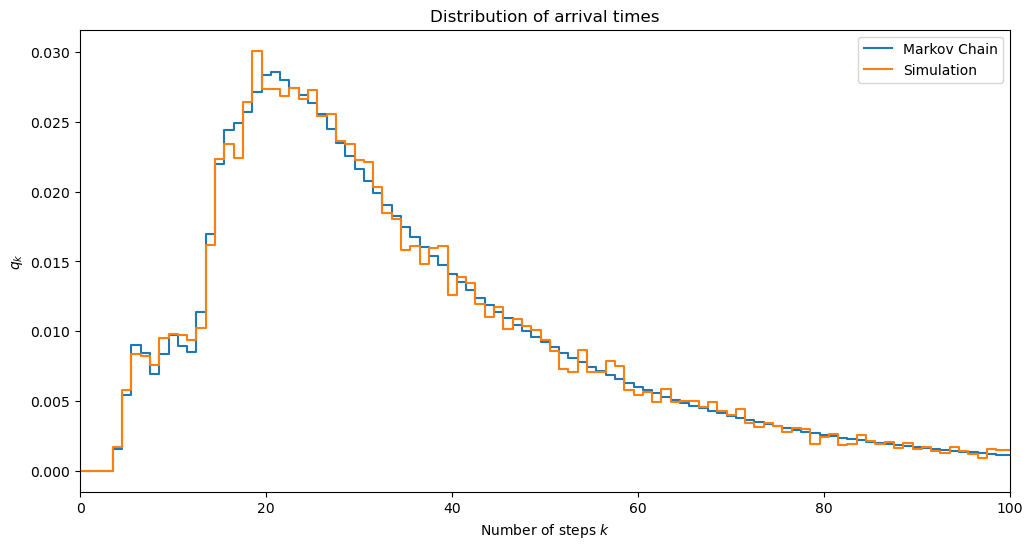

In [142]:
plt.step(range(len(qL)), qL, where='mid', label='Markov Chain');
plt.step(range(len(qE)), qE, where='mid', label='Simulation');
plt.title('Distribution of arrival times')
plt.xlabel('Number of steps $k$');
plt.ylabel('$q_k$')
plt.xlim(0, 100)
plt.legend();

Markov chain analysis and simulation are apparently in good agreement. This qualitative statement based on visual inspection (which may be misleading) should be substantiated by a proper statistical test, cf *Extensions* below.

#### Games with multiple players

In order to find the distribution of the arrival time for the first of $N$ (identical) players in a game, we can use results from [order statistics](http://en.wikipedia.org/wiki/Order_statistic). If $T_n$ is the random variable representing the arrival time of walker $n$, then we are interested in the distribution of $\min \{T_1, T_2, ..., T_N\}$, where all $T_n$ are independently and identically distributed according to the discrete distribution $q_k$. From [David and Nagaraja (1992, Eq 2.1.3)](http://books.google.no/books?id=bdhzFXg6xFkC&dq=Arnold,+B.+C.,+N.+Balakrishnan,+H.+N.+Nagaraja.+1992.+A+First+Course+in+Order+Statistics.+Wiley,+New+York.&hl=no&source=gbs_navlinks_s), we obtain the cumulative distribution of the minimum of $N$ random variables i.i.d. with cumulative distribution $Q_k$ as
$$R^{(N)}_k = 1 - ( 1 - Q_k )^N$$
and the corresponding distribution as
$$r^{(N)}_k = R^{(N)}_k - R^{(N)}_{k-1}\;.$$
See also [Evans et al (2006)](http://www.math.wm.edu/~leemis/2006informsjoc.pdf) (only available as `http://`, not as `https://`).

We consider a game with four players.

In [143]:
N = 4
RL = 1 - (1 - QL)**N
rL = np.zeros_like(RL)   # fiddle a little to avoid zero-indexing trouble
rL[1:] = np.diff(RL)

In [144]:
dN = Experiment(board=Board(goal=90, chutes_and_ladders=cnl),
                num_games=20000, num_players=N, seed=1234567).execute()
rE = np.zeros(max(dN)+1, dtype=float)
for n in frozenset(dN):
    rE[n] = dN.count(n)
rE /= len(dN)

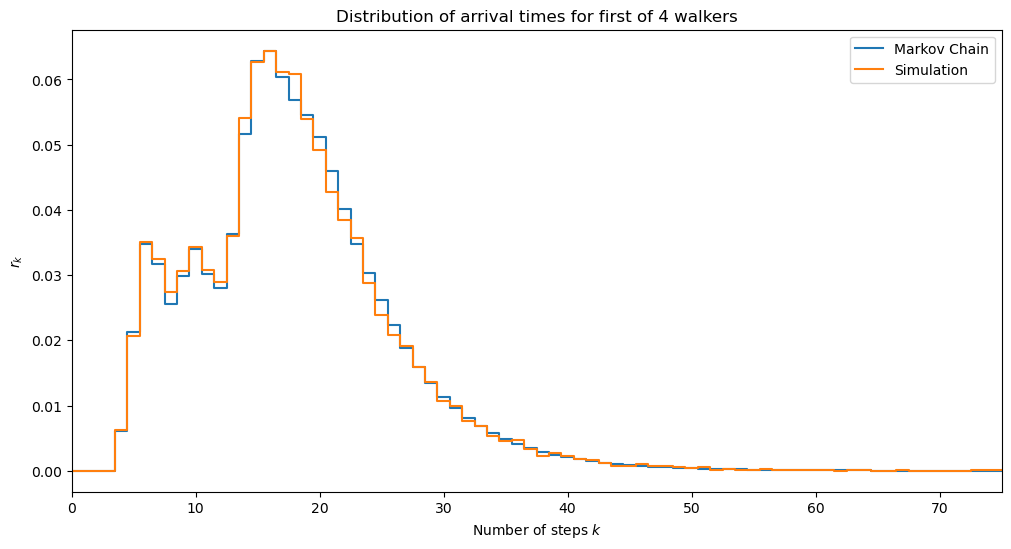

In [145]:
plt.step(range(len(rL)), rL, where='mid', label='Markov Chain');
plt.step(range(len(rE)), rE, where='mid', label='Simulation');
plt.title('Distribution of arrival times for first of {:d} walkers'.format(N))
plt.xlabel('Number of steps $k$');
plt.ylabel('$r_k$');
plt.legend();
plt.xlim(0, 75);

Also in this case theory and simulation appear to agree very well; see *Extensions* below for a note on statistical tests for distributions. As a sanity check, we check that no-one arrived in fewer than four moves, and that $R_k^{(4)}	\to1$ for $k	\to\infty$:

In [146]:
print(RL[3], RL[4])
print(1 - RL[-1])

0.0 0.006158565220760082
0.0


### Extensions

#### Statistical tests for distributions
Above, we compared distributions obtained numerically by Markov chain analysis with distributions obtained from simulations by visual inspection. While this is a useful first step (*always* look at your data before applying statistical analysis!), it may also be misleading. To draw solid conclusions, we need to apply statistical tests to check whether the simulation results follow the distribution obtained from Markov chain analysis.

For continuous random variables, e.g., variables following a Gaussian or exponential distribution, the proper test is the [Kolmogorov-Smirnov test](http://itl.nist.gov/div898/handbook/eda/section3/eda35g.htm), which is available as [`scipy.stats.kstest`](http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html).

The distribution of game durations, though, is a discrete distribution and we need to apply the [$\chi^2$-test](http://itl.nist.gov/div898/handbook/eda/section3/eda35f.htm), which is available as [`scipy.stats.chisquare`](http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html). In this test, we compare the number of times each game duration has been observed with the number predicted, $n_k=q_k\times N$, where $N$ is then number of games played. To be valid, the $\chi^2$-test requires that $n_k >5\; \forall k$. In order to ensure that this is fulfilled, we proceed as follows:

1. Find $k_{\mathrm{max}}$, the game duration for with highest probability $q_k$. The distribution for $k>k_{\mathrm{max}}$ is essentially the tail of the distribution, while the part $k<k_{\mathrm{max}}$ is the interesting part.
1. Find $k_{\mathrm{min}} < k_{\mathrm{max}}$, the game duration for which $q_k$ is smallest (but non-zero), to the left of the maximum.
1. Choose $N$ so that $N\times q_{k_{\mathrm{min}}}>5$.
1. Find $k_{\mathrm{tail}}$ as the largest $k$ for which both of the following conditions are fulfilled:

    1. $N\times q_k>5$
    1. $(1-Q_k)\times N>5$

   Condition A. ensures that the expectation for the rightmost bin, $k_{\mathrm{tail}}$ is more than 5, while B. ensures that the remaining tail, which we will collapse into a single bin, also has an expectation of at least 5.
1. Simulate $N$ games.
1. Each game duration $k$ forms one *bin* for the $\chi^2$-test, except that all game durations $k>k_{\mathrm{tail}}$ are combined in a single bin. The expectation for this bin is $n_{\mathrm{tail}}=(1-Q_{k_\mathrm{tail}})\times N$.
1. Apply the $\chi^2$-test to the data.

#### Using sparse matrices
For very large matrices, it may be useful to consider *sparse matrix* implementations from SciPy, which do not store all the zeros elements in $M$ and $L$.

### Using more suitable color maps

- The color maps we used above were not optimal due to limited contrast
- We will look at better color maps here
- We first define functions to
    - create a propagator matrix M for a given game board
    - evolve the state of the game over time
    - extract the arrival-time distribution

In [147]:
def propagator(chutes_and_ladders=None, goal=90):
    cnl = chutes_and_ladders if chutes_and_ladders else {
             1: 40, 8: 10, 36: 52, 43: 62, 49: 79, 65: 82, 68: 85,
             24: 5, 33: 3, 42: 30, 56: 37, 64: 27, 74: 12, 87: 70}
    
    M = np.zeros((goal+1, goal+1))
    M[goal, goal] = 1
    M[goal, (goal-6):goal] = np.array([1., 2., 3., 4., 5., 6.]) / 6.
    for i in range(1, goal):
        M[i, max(0, i-6):i] = 1./6.
        
    L = M.copy()
    for start, dest in cnl.items():
        L[start, :] = 0.
        L[dest, :] += M[start, :]
        
    return L

In [148]:
def evolve(prop, num_moves, initial=None):
    r, c = prop.shape
    assert r == c, "Propagator must be square"
    if initial is None:
        initial = np.zeros(r)
        initial[0] = 1
    else:
        assert len(initial) == r, "Initial size wrong"
    
    p = np.zeros((r, num_moves+1))
    p[:, 0] = initial
    
    for k in range(1, num_moves+1):
        p[:, k] = prop @ p[:, k-1]
        
    return p    

In [149]:
def arrival_dist(p_evol):
    Q = p_evol[-1, :]
    q = np.zeros_like(Q)
    q[1:] = np.diff(Q)
    return q, Q

#### Propagator matrix—standard color map

In [150]:
prop90 = propagator()

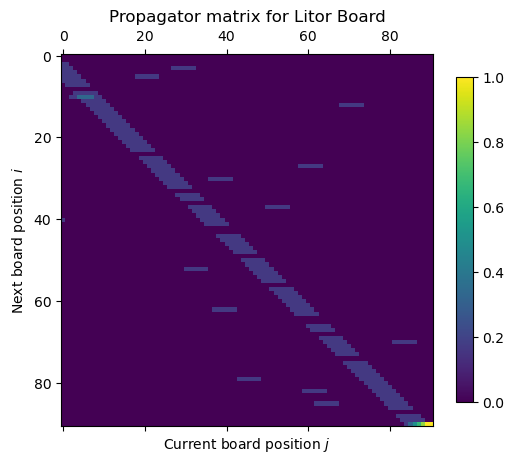

In [151]:
plt.matshow(prop90)
plt.xlabel('Current board position $j$');
plt.ylabel('Next board position $i$');
plt.title('Propagator matrix for Litor Board');
plt.colorbar(shrink=0.7);

- Problems with the figure above: 
    - all values in the matrix are either 0 or a multiple of 1/6
    - this is not clear from the color scale
    - actual values are difficult to read off
    - color scale is not linear in any sense
- Solution: Alternative color map
    - See [Choosing colormaps](http://matplotlib.org/users/colormaps.html) and [Colormaps reference](http://matplotlib.org/examples/color/colormaps_reference.html)
    - See also [this presentation on the default colormap in Matplotlib 2.0](https://bids.github.io/colormap/)
- Some of the examples below are based on ideas from
    - http://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar
    - http://pyhogs.github.io/colormap-examples.html

##### Step 1: Use a perceptually uniform color map

- Lightness changes uniformly over range of color map
- The `_r` suffix on the name reverses the color map, so that 0 is darkest
- For clarity, we use a small matrix and drop axis decorations

In [152]:
import matplotlib.cm as cm

In [153]:
propsmall = propagator(chutes_and_ladders={3: 5, 10: 15, 7: 2, 16:12}, 
                       goal=20)

In [154]:
plt.matshow(propsmall, cmap=cm.YlGnBu_r)
plt.colorbar(shrink=0.7);

##### Step 2: Discrete color map with values 0, 1/6, 2/6, ..., 1

- Seven different colors needed
- We can just get a color map with the necessary number of levels

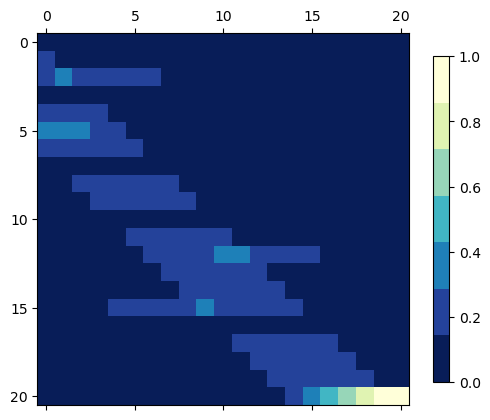

In [155]:
cm7 = cm.get_cmap('YlGnBu_r', 7)
plt.matshow(propsmall, cmap=cm7)
plt.colorbar(shrink=0.7);

- The axis label are now not very helpful
- We can change the placement of the labels

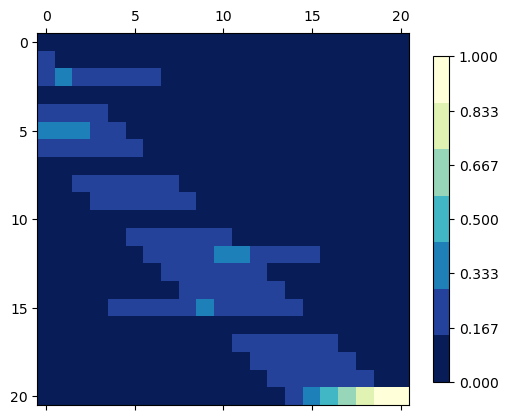

In [156]:
cm7 = cm.get_cmap('YlGnBu_r', 7)
plt.matshow(propsmall, cmap=cm7)
cax = plt.colorbar(shrink=0.7);
cax.set_ticks(np.linspace(0, 1, 7));

- Better, but it would be even nicer to place the markers in the center of the boxes and show fractions
- For $n$ boxes, the box centers are placed at

$$y_k = \frac{1}{2n} + \frac{k}{n} \quad k = 0, 1, \dots, n-1$$

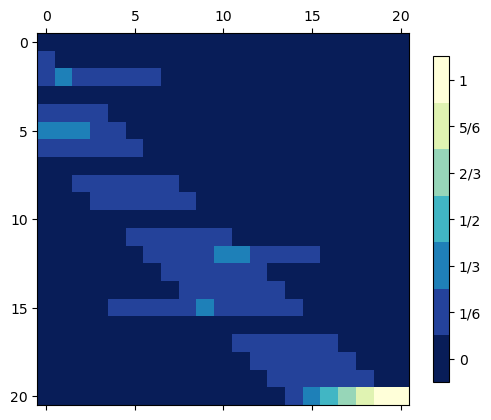

In [157]:
cm7 = cm.get_cmap('YlGnBu_r', 7)
plt.matshow(propsmall, cmap=cm7)
cax = plt.colorbar(shrink=0.7);
cax.set_ticks(np.arange(0., 7.) / 7. + 1./14.);
cax.set_ticklabels(('0', '1/6', '1/3', '1/2', '2/3', '5/6', '1'));

##### Step 3: change representation of zero probability for better contrast

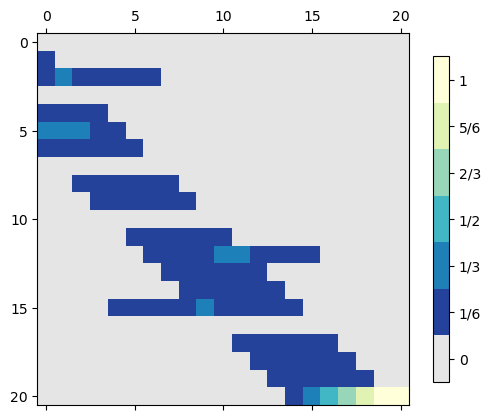

In [158]:
cm7 = cm.get_cmap('YlGnBu_r', 7)
cm7list = [cm7(i) for i in range(cm7.N)]
cm7list[0] = [0.9, 0.9, 0.9]
cm7mod = cm7.from_list('mymap', cm7list, cm7.N)
plt.matshow(propsmall, cmap=cm7mod)
cax = plt.colorbar(shrink=0.7);
cax.set_ticks(np.arange(0., 7.) / 7. + 1./14.);
cax.set_ticklabels(('0', '1/6', '1/3', '1/2', '2/3', '5/6', '1'));

#### Time evolution of residence probability

- We will use a similar color map as above for the time evolution, but with full resolution
- We will mark values below a certain limit with a separat color

In [159]:
p90 = evolve(prop90, 200)

In [160]:
import copy

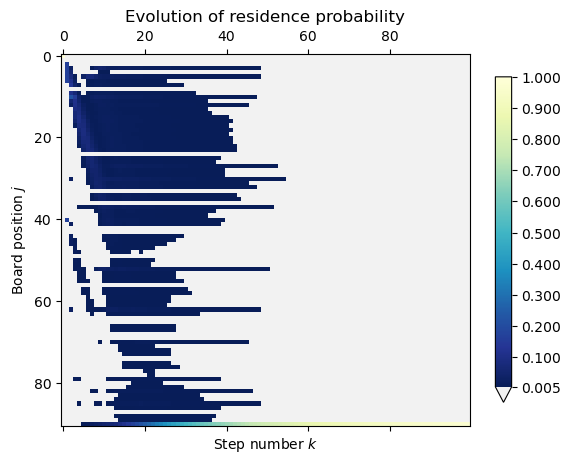

In [161]:
p_cutoff = 0.005

cm_p = copy.copy(cm.get_cmap('YlGnBu_r'))
cm_p.set_under((0.95, 0.95, 0.95))
plt.matshow(p90[:, :100], cmap=cm_p, vmin=p_cutoff)
plt.xlabel('Step number $k$');
plt.ylabel('Board position $j$');
plt.title('Evolution of residence probability');
cax = plt.colorbar(shrink=0.7, extend='min');
cax.set_ticks([p_cutoff] + list(np.arange(0.1, 1.01, 0.1)));

##### Step 4: Zooming in on parts of the color scale

- We can use different normalizations for the color scale to make important parts of the figure more visible
- Here, we use a power norm $x^\gamma$

In [162]:
from matplotlib.colors import PowerNorm

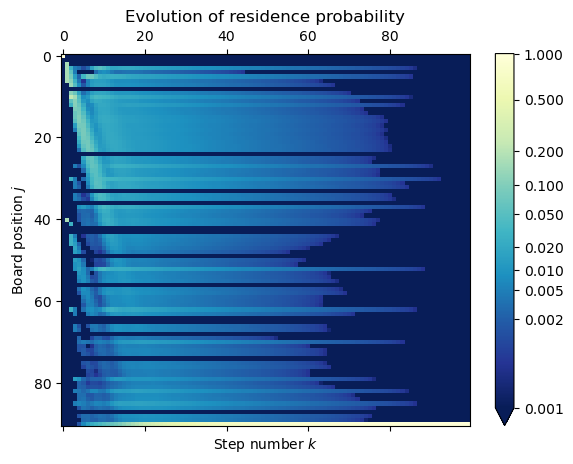

In [163]:
p_cutoff = 0.001
cm_p = copy.copy(cm.get_cmap('YlGnBu_r'))
cm_p.set_under((0.95, 0.95, 0.95))
plt.matshow(p90[:, :100], cmap=cm_p,
            norm=PowerNorm(gamma=0.2, vmin=p_cutoff, vmax=1))
plt.xlabel('Step number $k$');
plt.ylabel('Board position $j$');
plt.title('Evolution of residence probability');
cax = plt.colorbar(shrink=0.8, extend='min');
cax.set_ticks([p_cutoff, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]);